In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
#import regionmask
from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


In [2]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


## Read in simulation data

In [6]:
# Define path and filenames 
dataDir = '/glade/work/mdfowler/data/CESM2_zetaMax2/'
fileCAM = 'f.e21.FHIST_BGC.f09_f09.cesm2_cam6_clm5_z2.001.cam.h1.1979-1993_CIvars.nc'
fileCLM = 'f.e21.FHIST_BGC.f09_f09.cesm2_cam6_clm5_z2.001.clm2.h1.1979-1993_CIvars.nc'

# Read in the files 
camDF = xr.open_dataset(dataDir+fileCAM, decode_times=True)
clmDF = xr.open_dataset(dataDir+fileCLM, decode_times=True)
# Make time more usable 
camDF['time'] = camDF.indexes['time'].to_datetimeindex()
clmDF['time'] = clmDF.indexes['time'].to_datetimeindex()

# Save lat and lon in single arrays
lat = camDF.lat.values
lon = camDF.lon.values


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # Remove the CWD from sys.path while we load stuff.
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # This is added back by InteractiveShellApp.init_path()


In [4]:
# Compute LCL 
fileOutName = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-zetamax2.p'
#lclPath     = ComputeLCLpressure(dataDir+fileCAM,'PS','TREFHT','RHREFHT',fileOutName)
LCL         = pickle.load( open(fileOutName, "rb") )

Number of files: 

 1


/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/ComputeLCLpressure_function.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sfc_full['time'] = sfc_full.indexes['time'].to_datetimeindex()


Data starts at:  1979-01-01T00:00:00.000000000
Data ends at:    1994-01-01T00:00:00.000000000
Done with  0.0  % of days
Done with  10.007304601899197  % of days
Done with  20.014609203798393  % of days
Done with  30.021913805697594  % of days
Done with  40.02921840759679  % of days
Done with  50.03652300949598  % of days
Done with  60.04382761139519  % of days
Done with  70.05113221329438  % of days
Done with  80.05843681519357  % of days
Done with  90.06574141709277  % of days
Finished computing LCL-pressure level successfully and saved pickle file:
/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-zetamax2.p


In [7]:
# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(camDF['time'].values)


In [8]:
# Read in land mask 
filePath = '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.1976-01-01-00000.nc'
exDF     = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan


## Compute coupling index for new simulation

In [14]:
# Combine soil moisture and CAM variables into single DF 
dFull = camDF 
dFull['soilM_10'] = (('time','lat','lon'), clmDF.SOILWATER_10CM.values)
dFull['Plcl'] = (('time','lat','lon'), LCL)

In [10]:
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull, xname='soilM_10',yname='LHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_CESM2-zetamax2.nc')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Terrestrial Coupling Index (10cm SM and LHFLX) [JJA]')

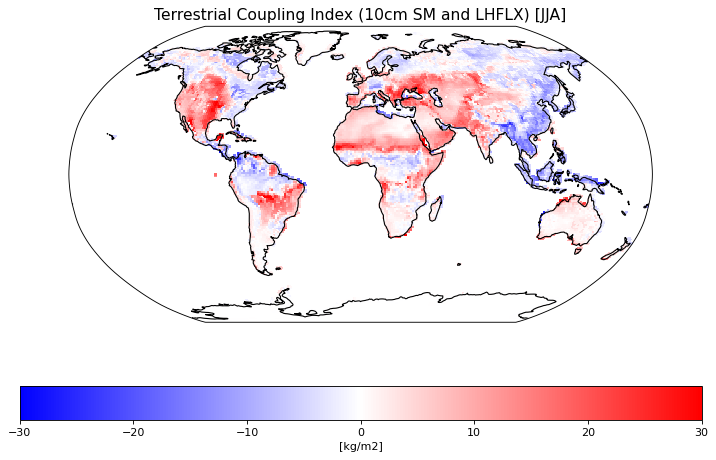

In [11]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
terraCoupl_JJA, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(terra_coupling.soilM_10_LHFLX_CI[1,:,:]), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,terraCoupl_JJA,vmin=-30,vmax=30,cmap='bwr',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[kg/m2]',orientation='horizontal')
ax.set_title('Terrestrial Coupling Index (10cm SM and LHFLX) ['+np.asarray(terra_coupling.season)[1]+']', fontsize=14)


In [12]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling = cm.metrics.CouplingIndex()
terraLeg_coupling = terraLeg_coupling.compute(dFull, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terraLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CESM2-zetamax2.nc')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [15]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling = cm.metrics.CouplingIndex()
atmoLeg_coupling = atmoLeg_coupling.compute(dFull, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file 
atmoLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CESM2-zetamax2.nc')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Read in CI from files (for multiple model versions)

In [17]:
# Load in pickle files: 
#dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'
dataDir = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/'

# ----------------------------
#  CESM2 - zetamax=2 
# ----------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-zetamax2.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-zetamax2.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-zetamax2.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_zeta2  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_zeta2 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_zeta2  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

# ----------------------------
#   CESM2 (CAM6, CLM5)
# ----------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_1979-2006.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_1979-2006.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_1979-2006.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM2  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM2 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM2  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

# ----------------------------
#   CESM1 (CAM5, CLM4)
# ----------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM1.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM1.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM1.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM1  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM1 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM1  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

# ----------------------------
#   CLM4.5 (CAM6, CLM4.5)
# ----------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CLM45.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CLM45.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CLM45  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CLM45 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CLM45  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


# ----------------------------
#  Pick out lat/lon values
# ----------------------------
lat = atmoLeg_CESM2.lat.values
lon = atmoLeg_CESM2.lon.values



## Now plot comparisons

**Set up color maps**

In [18]:
### Create a list of RGB tuples
colorsList_SMvLHF = [(127,58,144), 
                     (67,81,163),
                     (0,191,243),
                     (194,229,220),
                     (124,194,66),
                     (227,219,46),
                     (250,175,44),
                     (245,127,36), 
                     (239,67,54),
                     (238,45,122),
                     (162,6,66)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap_SMvLHF = make_cmap(colorsList_SMvLHF, bit=True)



### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)



### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)


In [19]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
AtmoLeg_JJA_cesm1  = np.squeeze(np.asarray(atmoLeg_CESM1.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm1 = np.squeeze(np.asarray(terraLeg_CESM1.soilM_10_SHFLX_CI[1,:,:]))
AtmoLeg_JJA_cesm2  = np.squeeze(np.asarray(atmoLeg_CESM2.hfss_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm2 = np.squeeze(np.asarray(terraLeg_CESM2.mrsos_hfss_CI[1,:,:]))
AtmoLeg_JJA_clm45  = np.squeeze(np.asarray(atmoLeg_CLM45.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm45 = np.squeeze(np.asarray(terraLeg_CLM45.soilM_10_SHFLX_CI[1,:,:]))
AtmoLeg_JJA_zeta2   = np.squeeze(np.asarray(atmoLeg_zeta2.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_zeta2  = np.squeeze(np.asarray(terraLeg_zeta2.soilM_10_SHFLX_CI[1,:,:]))

# Make cyclic first 
AtmoLeg_JJA_cyclic_cesm1, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm1, lon)
TerraLeg_JJA_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm1, lon)
AtmoLeg_JJA_cyclic_cesm2, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm2, lon)
TerraLeg_JJA_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm2, lon)
AtmoLeg_JJA_cyclic_clm45, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_clm45, lon)
TerraLeg_JJA_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_clm45, lon)
AtmoLeg_JJA_cyclic_zeta2, lon_cyclic   = cartopy.util.add_cyclic_point(AtmoLeg_JJA_zeta2, lon)
TerraLeg_JJA_cyclic_zeta2, lon_cyclic  = cartopy.util.add_cyclic_point(TerraLeg_JJA_zeta2, lon)


# Now get color coded arrays 
colorsAtmoLeg_cesm1  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cesm2  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_clm45  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_zeta2   = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_zeta2  = np.full([len(lat),len(lon)+1],np.nan)

# ----- CESM 1 ------

# Atmo leg 
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1<-150)]                                 = 1
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-150) & (AtmoLeg_JJA_cyclic_cesm1<=-100))]  = 2
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-100) & (AtmoLeg_JJA_cyclic_cesm1<=-50))]   = 3
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-50)  & (AtmoLeg_JJA_cyclic_cesm1<=-20))]   = 4
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-20)  & (AtmoLeg_JJA_cyclic_cesm1<=0))]     = 5
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>0)    & (AtmoLeg_JJA_cyclic_cesm1<=20))]    = 6
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>20)   & (AtmoLeg_JJA_cyclic_cesm1<=40))]    = 7
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>40)   & (AtmoLeg_JJA_cyclic_cesm1<=60))]    = 8
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>60)   & (AtmoLeg_JJA_cyclic_cesm1<=80))]    = 9
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>80)   & (AtmoLeg_JJA_cyclic_cesm1<=100))]   = 10
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1<-20)]                                 = 1
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-20) & (TerraLeg_JJA_cyclic_cesm1<=-15))]  = 2
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-15) & (TerraLeg_JJA_cyclic_cesm1<=-10))]  = 3
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-10) & (TerraLeg_JJA_cyclic_cesm1<=-5))]   = 4
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-5) & (TerraLeg_JJA_cyclic_cesm1<=-2))]    = 5
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-2) & (TerraLeg_JJA_cyclic_cesm1<=-1))]    = 6
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-1) & (TerraLeg_JJA_cyclic_cesm1<=0))]     = 7
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1>0)]                                   = 8


# ----- CESM 2 ------

# Atmo leg 
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2<-150)]                                 = 1
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-150) & (AtmoLeg_JJA_cyclic_cesm2<=-100))]  = 2
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-100) & (AtmoLeg_JJA_cyclic_cesm2<=-50))]   = 3
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-50)  & (AtmoLeg_JJA_cyclic_cesm2<=-20))]   = 4
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-20)  & (AtmoLeg_JJA_cyclic_cesm2<=0))]     = 5
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>0)    & (AtmoLeg_JJA_cyclic_cesm2<=20))]    = 6
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>20)   & (AtmoLeg_JJA_cyclic_cesm2<=40))]    = 7
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>40)   & (AtmoLeg_JJA_cyclic_cesm2<=60))]    = 8
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>60)   & (AtmoLeg_JJA_cyclic_cesm2<=80))]    = 9
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>80)   & (AtmoLeg_JJA_cyclic_cesm2<=100))]   = 10
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2<-20)]                                 = 1
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-20) & (TerraLeg_JJA_cyclic_cesm2<=-15))]  = 2
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-15) & (TerraLeg_JJA_cyclic_cesm2<=-10))]  = 3
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-10) & (TerraLeg_JJA_cyclic_cesm2<=-5))]   = 4
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-5) & (TerraLeg_JJA_cyclic_cesm2<=-2))]    = 5
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-2) & (TerraLeg_JJA_cyclic_cesm2<=-1))]    = 6
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-1) & (TerraLeg_JJA_cyclic_cesm2<=0))]     = 7
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2>0)]                                   = 8



# ----- CLM4.5 ------

# Atmo leg 
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45<-150)]                                 = 1
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-150) & (AtmoLeg_JJA_cyclic_clm45<=-100))]  = 2
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-100) & (AtmoLeg_JJA_cyclic_clm45<=-50))]   = 3
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-50)  & (AtmoLeg_JJA_cyclic_clm45<=-20))]   = 4
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-20)  & (AtmoLeg_JJA_cyclic_clm45<=0))]     = 5
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>0)    & (AtmoLeg_JJA_cyclic_clm45<=20))]    = 6
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>20)   & (AtmoLeg_JJA_cyclic_clm45<=40))]    = 7
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>40)   & (AtmoLeg_JJA_cyclic_clm45<=60))]    = 8
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>60)   & (AtmoLeg_JJA_cyclic_clm45<=80))]    = 9
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>80)   & (AtmoLeg_JJA_cyclic_clm45<=100))]   = 10
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45>100)]                                  = 11


# Terra leg  
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45<-20)]                                 = 1
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-20) & (TerraLeg_JJA_cyclic_clm45<=-15))]  = 2
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-15) & (TerraLeg_JJA_cyclic_clm45<=-10))]  = 3
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-10) & (TerraLeg_JJA_cyclic_clm45<=-5))]   = 4
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-5) & (TerraLeg_JJA_cyclic_clm45<=-2))]    = 5
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-2) & (TerraLeg_JJA_cyclic_clm45<=-1))]    = 6
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-1) & (TerraLeg_JJA_cyclic_clm45<=0))]     = 7
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45>0)]                                   = 8



# ----- CESM2_zetamax2 ------

# Atmo leg 
colorsAtmoLeg_zeta2[np.where(AtmoLeg_JJA_cyclic_zeta2<-150)]                                 = 1
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>-150) & (AtmoLeg_JJA_cyclic_zeta2<=-100))]  = 2
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>-100) & (AtmoLeg_JJA_cyclic_zeta2<=-50))]   = 3
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>-50)  & (AtmoLeg_JJA_cyclic_zeta2<=-20))]   = 4
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>-20)  & (AtmoLeg_JJA_cyclic_zeta2<=0))]     = 5
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>0)    & (AtmoLeg_JJA_cyclic_zeta2<=20))]    = 6
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>20)   & (AtmoLeg_JJA_cyclic_zeta2<=40))]    = 7
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>40)   & (AtmoLeg_JJA_cyclic_zeta2<=60))]    = 8
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>60)   & (AtmoLeg_JJA_cyclic_zeta2<=80))]    = 9
colorsAtmoLeg_zeta2[np.where((AtmoLeg_JJA_cyclic_zeta2>80)   & (AtmoLeg_JJA_cyclic_zeta2<=100))]   = 10
colorsAtmoLeg_zeta2[np.where(AtmoLeg_JJA_cyclic_zeta2>100)]                                  = 11


# Terra leg  
colorsTerraLeg_zeta2[np.where(TerraLeg_JJA_cyclic_zeta2<-20)]                                 = 1
colorsTerraLeg_zeta2[np.where((TerraLeg_JJA_cyclic_zeta2>-20) & (TerraLeg_JJA_cyclic_zeta2<=-15))]  = 2
colorsTerraLeg_zeta2[np.where((TerraLeg_JJA_cyclic_zeta2>-15) & (TerraLeg_JJA_cyclic_zeta2<=-10))]  = 3
colorsTerraLeg_zeta2[np.where((TerraLeg_JJA_cyclic_zeta2>-10) & (TerraLeg_JJA_cyclic_zeta2<=-5))]   = 4
colorsTerraLeg_zeta2[np.where((TerraLeg_JJA_cyclic_zeta2>-5) & (TerraLeg_JJA_cyclic_zeta2<=-2))]    = 5
colorsTerraLeg_zeta2[np.where((TerraLeg_JJA_cyclic_zeta2>-2) & (TerraLeg_JJA_cyclic_zeta2<=-1))]    = 6
colorsTerraLeg_zeta2[np.where((TerraLeg_JJA_cyclic_zeta2>-1) & (TerraLeg_JJA_cyclic_zeta2<=0))]     = 7
colorsTerraLeg_zeta2[np.where(TerraLeg_JJA_cyclic_zeta2>0)]                                   = 8



/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less_equal
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less_equal
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less_equal
/glade/

In [20]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask = np.full([len(lat),len(lon)+1],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_JJA_cyclic_cesm1))] = 1


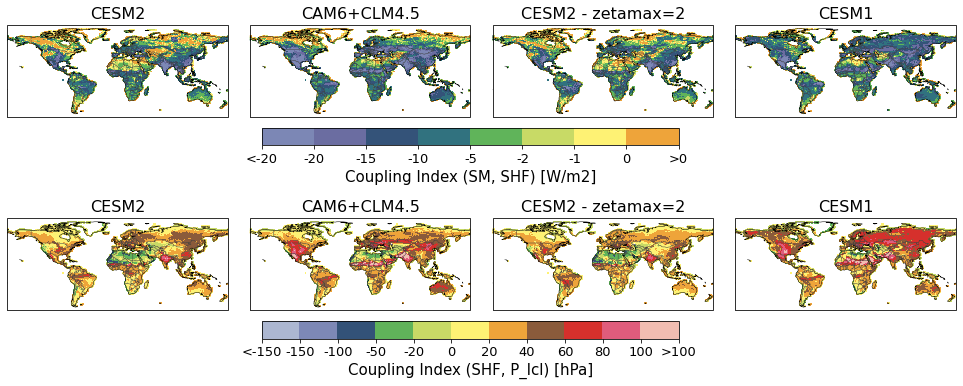

In [21]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
# axs[0].gridlines()
# axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsTerraLeg_clm45,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=13)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_clm45*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=15)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=13)  # vertically oriented colorbar


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[5].set_title('CAM6+CLM4.5',fontsize=16)
# axs[1].gridlines()
# axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot CESM2-zeta2 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsTerraLeg_zeta2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[6].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_zeta2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[2].set_title('CESM2 - zetamax=2',fontsize=16)
axs[6].set_title('CESM2 - zetamax=2',fontsize=16)
# axs[2].gridlines()
# axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm1,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm1*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[7].set_title('CESM1',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



### Difference plots

In [22]:
atmoDiff_CESM2vCESM1 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_cesm1  # Impact of upgrading CAM and CLM 
atmoDiff_CESM2vCLM45 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_clm45  # Impact of upgrading CAM 
atmoDiff_CESM2vZETA2  = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_zeta2   # Impact of changing zeta 

terraDiff_CESM2vCESM1 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_cesm1 # Impact of upgrading CAM and CLM  
terraDiff_CESM2vCLM45 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_clm45 # Impact of upgrading CAM 
terraDiff_CESM2vZETA2  = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_zeta2  # Impact of changing zeta 


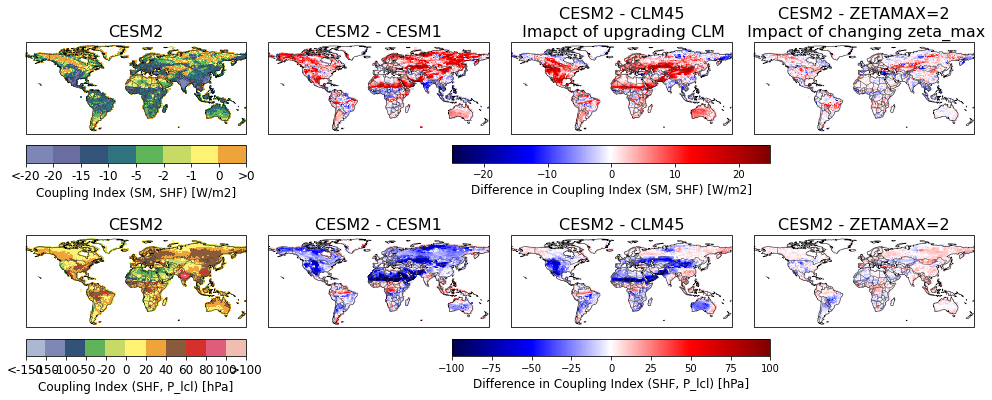

In [27]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=12)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=12)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=12)  # vertically oriented colorbar


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
# axs[0].gridlines()
# axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-25,vmax=25)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.15, ax_position.y0-0.05, ax_position.width+0.08, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SM, SHF) [W/m2]',fontsize=12)

contour_plot = axs[5].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.15, ax_position.y0-0.05, ax_position.width+0.08, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
# axs[1].gridlines()
# axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-25,vmax=25)

contour_plot = axs[6].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
# axs[2].gridlines()
# axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of changing zeta in CLM5----- 
#   ...Diff_CESM2vZETA2
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vZETA2,
                             cmap='seismic',
                             vmin=-25,vmax=25)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vZETA2*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[3].set_title('CESM2 - ZETAMAX=2\n Impact of changing zeta_max',fontsize=16)
axs[7].set_title('CESM2 - ZETAMAX=2',fontsize=16)
# axs[3].gridlines()
# axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
